# Example 2: Cytotoxicity Contact Analysis

In this notebook we will demonstrate:
1. Convert segmented label data to sparse Pandas table
2. Use the label and sparse position table to return contact analysis across multiple frames
3. Simple plot of the contact time with the contact table output

In [7]:
from cyto.postprocessing.graph import *
from cyto.utils.label_to_table import *
import dask_image.imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pyclesperanto_prototype as cle

## Load image files
pyCyto supports any image loader compatible with numpy/dask. Bioimages may storage in multiple formats and dimension orders. Here we load list of single image files under same directory with Dask Image, utilizing the lazy loading function to facilitate the pipeline optimization. For large dataset dask array is more preferable than numpy for better memory managements.

In [2]:
CANCER_IMAGE_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/register_denoise_gamma_channel_merged_cancer_ROI/*.tif"
TCELL_IMAGE_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/register_denoise_gamma_channel_merged_Tcell_ROI/*.tif"

CANCER_LABEL_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/register_denoise_gamma_channel_merged_cancer_ROI_masks/*.tif"
TCELL_LABEL_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/register_denoise_gamma_channel_merged_Tcell_ROI_masks/*.tif"

In [3]:
# default chunk size: 1 image
image_cancer = dask_image.imread.imread(CANCER_IMAGE_PATH_PATTERN)
image_tcell = dask_image.imread.imread(TCELL_IMAGE_PATH_PATTERN)

label_cancer = dask_image.imread.imread(CANCER_LABEL_PATH_PATTERN)
label_tcell = dask_image.imread.imread(TCELL_LABEL_PATH_PATTERN)

image_cancer

dask.array<_map_read_frame, shape=(8640, 1000, 1000), dtype=uint16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>

Have a first glance of the images

Text(0.5, 1.0, 'T Cell Labels')

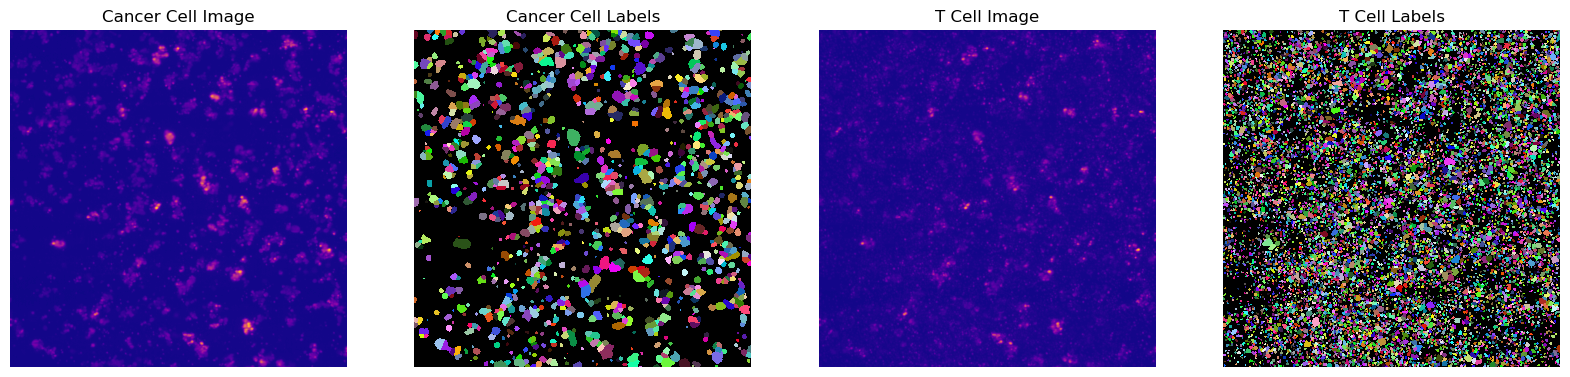

In [6]:
fig, axs = plt.subplots(1,4,figsize=(20,5))

axs[0].imshow(image_cancer[0,:,:],cmap="plasma")
axs[0].set_axis_off()
axs[0].set_title("Cancer Cell Image")

cle.imshow(label_cancer[0,:,:], labels=True, plot=axs[1])
axs[1].set_axis_off()
axs[1].set_title("Cancer Cell Labels")

axs[2].imshow(image_tcell[0,:,:],cmap="plasma")
axs[2].set_axis_off()
axs[2].set_title("T Cell Image")

cle.imshow(label_tcell[0,:,:], labels=True, plot=axs[3])
axs[3].set_axis_off()
axs[3].set_title("T Cell Labels")


## Prepare input data dictionary for pyCyto

In [8]:
FRAMES = 10 # define number of frames to perform contact analysis

In [9]:
# convert segmentation mask to trackpy style array
features = {}

# note that pyCyto works in XYT dim order but dask/tiff is in TYX, need to transpose the array
# TODO: pixel spacing
features["cancer"] = label_to_sparse(label=label_cancer[:10,:,:].T,image=image_cancer[:10,:,:].T,spacing=[1,1],channel_name="cancer")

features["tcell"] = label_to_sparse(label=label_tcell[:10,:,:].T,image=image_tcell[:10,:,:].T,spacing=[1,1],channel_name="tcell")

100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


In [10]:
features["cancer"]

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,feret_diameter,feret_radius,perimeter,mass,mean,median,sd,frame,channel,alive
0,1,472.585952,317.597659,293,453,52,42,317.597659,472.585952,293.0,...,53.488316,26.744158,148.801077,15623847.0,9626.523105,9228.855469,4698.160008,0,cancer,NaN
1,2,142.222810,633.487915,617,115,34,53,633.487915,142.222810,617.0,...,52.345009,26.172505,144.223441,11211521.0,8467.916163,7659.214844,4185.782957,0,cancer,NaN
2,3,535.442224,748.133797,725,518,55,37,748.133797,535.442224,725.0,...,56.612719,28.306360,143.342758,6819866.0,5925.165943,6089.574219,1770.658758,0,cancer,NaN
3,4,685.534222,434.730667,412,665,44,43,434.730667,685.534222,412.0,...,46.324939,23.162470,135.988320,6567633.0,5837.896000,5865.339844,1607.486737,0,cancer,NaN
4,5,606.487106,197.601719,179,587,38,41,197.601719,606.487106,179.0,...,41.761226,20.880613,121.470014,10382658.0,9916.578797,8219.800781,5744.402120,0,cancer,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11854,11855,415.529412,589.882353,588,414,5,4,589.882353,415.529412,588.0,...,5.000000,2.500000,14.843629,81660.0,4803.529412,4910.484375,854.373171,9,cancer,NaN
11855,11856,181.647059,913.941176,912,180,5,5,913.941176,181.647059,912.0,...,4.472136,2.236068,15.073666,74550.0,4385.294118,4359.390625,550.670587,9,cancer,NaN
11856,11857,447.647059,973.705882,972,446,5,4,973.705882,447.647059,972.0,...,5.000000,2.500000,16.739748,87457.0,5144.529412,5020.703125,821.077198,9,cancer,NaN
11857,11858,648.500000,600.000000,598,647,5,4,600.000000,648.500000,598.0,...,4.123106,2.061553,13.732908,86576.0,5411.000000,5351.359375,1154.235562,9,cancer,NaN


In [11]:
features["tcell"]

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,feret_diameter,feret_radius,perimeter,mass,mean,median,sd,frame,channel,alive
0,1,670.849246,390.738693,378,655,25,35,390.738693,670.849246,378.0,...,34.132096,17.066048,98.907157,3940048.0,6599.745394,6001.556641,2274.345323,0,tcell,NaN
1,2,132.066532,630.483871,618,116,24,32,630.483871,132.066532,618.0,...,31.400637,15.700318,90.537283,4193311.0,8454.256048,7269.779297,4148.664472,0,tcell,NaN
2,3,274.956790,865.415638,851,264,30,23,865.415638,274.956790,851.0,...,30.675723,15.337862,84.293566,3094097.0,6366.454733,5886.263672,1875.136901,0,tcell,NaN
3,4,691.069930,680.552448,667,675,25,28,680.552448,691.069930,667.0,...,30.232433,15.116216,82.167409,2948162.0,6872.172494,5770.970703,3270.370277,0,tcell,NaN
4,5,659.125874,729.431235,717,648,29,22,729.431235,659.125874,717.0,...,31.304952,15.652476,84.388851,2956619.0,6891.885781,6808.607422,1809.146731,0,tcell,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101885,101886,198.933333,990.600000,989,197,4,5,990.600000,198.933333,989.0,...,4.123106,2.061553,13.732908,52415.0,3494.333333,3556.425781,84.335780,9,tcell,NaN
101886,101887,450.466667,993.466667,992,449,4,5,993.466667,450.466667,992.0,...,4.472136,2.236068,14.288268,58088.0,3872.533333,3885.699219,137.495905,9,tcell,NaN
101887,101888,291.400000,995.933333,994,290,5,4,995.933333,291.400000,994.0,...,4.123106,2.061553,13.732908,57088.0,3805.866667,3775.941406,61.902996,9,tcell,NaN
101888,101889,388.200000,997.933333,996,386,4,5,997.933333,388.200000,996.0,...,4.472136,2.236068,14.288268,62353.0,4156.866667,4214.972656,255.121782,9,tcell,NaN
